In [1]:
# coding: utf-8
from __future__ import print_function
import os
import numpy as np
import time
np.random.seed(1337)

import theano
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten
from keras.layers import Convolution1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from keras.layers import Input, Dropout
from keras.optimizers import SGD, Adadelta
from keras.models import Sequential
import sys

BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.twitter.27B/'

TEXT_DATA_DIR = BASE_DIR + '/20_newsgroupsf/'

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
CONVOLUTION_FEATURE = 256
DENSE_FEATURE = 1024
DROP_OUT = 0.3

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
fname = os.path.join(GLOVE_DIR, 'glove.twitter.27B.' + str(EMBEDDING_DIM) + 'd.txt')
f = open(fname)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                texts.append(f.read())
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
# embedding_layer = Embedding(nb_words + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)

print('Training model.')

model = Sequential()

model.add(Embedding(                          # Layer 0, Start
    input_dim=nb_words + 1,                   # Size to dictionary, has to be input + 1
    output_dim=EMBEDDING_DIM,                 # Dimensions to generate
    weights=[embedding_matrix],               # Initialize word weights
    input_length=MAX_SEQUENCE_LENGTH))        # Define length to input sequences in the first layer

model.add(Convolution1D(                      # Layer 1,   Features: 256, Kernel Size: 7
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=7,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(MaxPooling1D(                       # Layer 1a,  Max Pooling: 3
    pool_length=3))                           # Size of kernels

model.add(Convolution1D(                      # Layer 2,   Features: 256, Kernel Size: 7
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=7,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(MaxPooling1D(                       # Layer 2a,  Max Pooling: 3
    pool_length=3))                           # Size of kernels

model.add(Convolution1D(                      # Layer 3,   Features: 256, Kernel Size: 3
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=3,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(Convolution1D(                      # Layer 4,   Features: 256, Kernel Size: 3
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=3,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(Convolution1D(                      # Layer 5,   Features: 256, Kernel Size: 3
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=3,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(Convolution1D(                      # Layer 6,   Features: 256, Kernel Size: 3
    nb_filter=CONVOLUTION_FEATURE,            # Number of kernels or number of filters to generate
    filter_length=5,                          # Size of kernels
    border_mode='valid',                      # Border = 'valid', cause kernel to reduce dimensions
    activation='relu'))                       # Activation function to use

model.add(MaxPooling1D(                       # Layer 6a,  Max Pooling: 3
    pool_length=3))                           # Size of kernels

model.add(Flatten())                          # Layer 7

model.add(Dense(                              # Layer 7a,  Output Size: 1024
    output_dim=DENSE_FEATURE,                 # Output dimension
    activation='relu'))                       # Activation function to use

model.add(Dropout(DROP_OUT))

model.add(Dense(                              # Layer 8,   Output Size: 1024
    output_dim=DENSE_FEATURE,                 # Output dimension
    activation='relu'))                       # Activation function to use

model.add(Dropout(DROP_OUT))

model.add(Dense(                              # Layer 9,  Output Size: Size Unique Labels, Final
    output_dim=len(labels_index),             # Output dimension
    activation='softmax')) 

#sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
#adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08)
sgd = SGD(lr=0.0003, momentum=0.9, nesterov=True)



model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

print("Done compiling.")

start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=25, batch_size=150)

print ("Compilation Time : ", time.time() - start)


Using gpu device 0: GeForce GTX 950 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)
Using Theano backend.


Indexing word vectors.
Found 1193514 word vectors.
Processing text dataset
Found 19997 texts.
Found 214909 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Training model.
Done compiling.
Train on 15998 samples, validate on 3999 samples
Epoch 1/25
15998/15998 [==============================] - 94s - loss: 2.9968 - acc: 0.0492 - val_loss: 2.9931 - val_acc: 0.0608

['acc', 'loss', 'val_acc', 'val_loss']


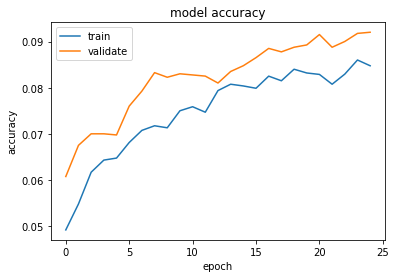

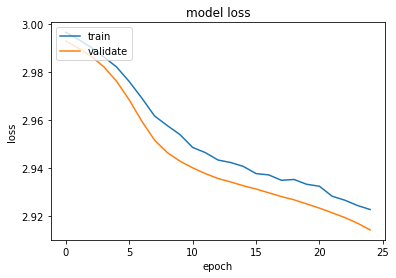

In [2]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [3]:
print(history.history)

{'acc': [0.049193649262386396, 0.054819352684512497, 0.061695212315978042, 0.064320540149475067, 0.064758094567174476, 0.068133516604825251, 0.07075884493943646, 0.07175896972872374, 0.071321415318010117, 0.07500937632943469, 0.075884485506438767, 0.074696837380344022, 0.079384923297485754, 0.08076009540820378, 0.080385048470991607, 0.079884985578493828, 0.082510313954088352, 0.081510188978047557, 0.084010501722962969, 0.083197899776121909, 0.082885360895957716, 0.080760094959250184, 0.082947868614893339, 0.086010751709507796, 0.084760595276040837], 'loss': [2.9967597222414621, 2.9937171413535131, 2.9904275374466782, 2.9864429472565486, 2.9822498501084835, 2.9761616821243759, 2.9691960059012277, 2.9617427015382063, 2.9577376295855857, 2.9539704345169477, 2.9485961870486057, 2.946425012565133, 2.943323919334655, 2.9422825629867035, 2.9406449671074189, 2.9376586772662607, 2.9370958871849777, 2.9348491230433038, 2.9351769383959003, 2.9331659977399402, 2.9323464939185628, 2.928183611638397

In [4]:
Indexing word vectors.
Found 1193514 word vectors.
Processing text dataset
Found 5000 texts.
Found 101187 unique tokens.
Shape of data tensor: (5000, 1000)
Shape of label tensor: (5000, 5)
Preparing embedding matrix.
Training model.
Done compiling.
Train on 4000 samples, validate on 1000 samples
Epoch 1/25
4000/4000 [==============================] - 22s - loss: 1.5720 - acc: 0.2608 - val_loss: 1.5010 - val_acc: 0.2910
Epoch 2/25
4000/4000 [==============================] - 22s - loss: 1.5738 - acc: 0.2807 - val_loss: 1.5713 - val_acc: 0.2520
Epoch 3/25
4000/4000 [==============================] - 22s - loss: 1.5210 - acc: 0.2983 - val_loss: 1.5879 - val_acc: 0.2590
Epoch 4/25
4000/4000 [==============================] - 22s - loss: 1.5712 - acc: 0.2720 - val_loss: 1.5869 - val_acc: 0.2510
Epoch 5/25
4000/4000 [==============================] - 22s - loss: 1.3297 - acc: 0.3573 - val_loss: 1.1850 - val_acc: 0.3900
Epoch 6/25
4000/4000 [==============================] - 22s - loss: 1.1450 - acc: 0.4065 - val_loss: 1.4187 - val_acc: 0.3460
Epoch 7/25
4000/4000 [==============================] - 22s - loss: 1.1386 - acc: 0.4148 - val_loss: 1.1482 - val_acc: 0.4030
Epoch 8/25
4000/4000 [==============================] - 22s - loss: 1.1194 - acc: 0.4305 - val_loss: 1.1356 - val_acc: 0.4160
Epoch 9/25
4000/4000 [==============================] - 22s - loss: 1.1198 - acc: 0.4293 - val_loss: 1.1287 - val_acc: 0.4230
Epoch 10/25
4000/4000 [==============================] - 22s - loss: 0.9964 - acc: 0.5168 - val_loss: 0.6412 - val_acc: 0.7540
Epoch 11/25
4000/4000 [==============================] - 22s - loss: 0.4745 - acc: 0.8565 - val_loss: 0.1868 - val_acc: 0.9670
Epoch 12/25
4000/4000 [==============================] - 22s - loss: 0.1943 - acc: 0.9603 - val_loss: 0.1747 - val_acc: 0.9470
Epoch 13/25
4000/4000 [==============================] - 22s - loss: 0.1264 - acc: 0.9695 - val_loss: 0.1661 - val_acc: 0.9670
Epoch 14/25
4000/4000 [==============================] - 22s - loss: 0.1172 - acc: 0.9718 - val_loss: 0.1201 - val_acc: 0.9770
Epoch 15/25
4000/4000 [==============================] - 22s - loss: 0.0964 - acc: 0.9762 - val_loss: 0.1666 - val_acc: 0.9690
Epoch 16/25
4000/4000 [==============================] - 22s - loss: 0.0835 - acc: 0.9792 - val_loss: 0.1124 - val_acc: 0.9780
Epoch 17/25
4000/4000 [==============================] - 22s - loss: 0.0992 - acc: 0.9720 - val_loss: 0.1042 - val_acc: 0.9800
Epoch 18/25
4000/4000 [==============================] - 22s - loss: 0.0765 - acc: 0.9815 - val_loss: 0.1589 - val_acc: 0.9530
Epoch 19/25
4000/4000 [==============================] - 22s - loss: 0.0689 - acc: 0.9825 - val_loss: 0.1224 - val_acc: 0.9790
Epoch 20/25
4000/4000 [==============================] - 22s - loss: 0.0779 - acc: 0.9822 - val_loss: 0.1385 - val_acc: 0.9740
Epoch 21/25
4000/4000 [==============================] - 22s - loss: 0.0559 - acc: 0.9855 - val_loss: 0.1299 - val_acc: 0.9740
Epoch 22/25
4000/4000 [==============================] - 22s - loss: 0.0625 - acc: 0.9835 - val_loss: 0.1157 - val_acc: 0.9780
Epoch 23/25
4000/4000 [==============================] - 22s - loss: 0.0630 - acc: 0.9832 - val_loss: 0.1243 - val_acc: 0.9730
Epoch 24/25
4000/4000 [==============================] - 22s - loss: 0.0598 - acc: 0.9848 - val_loss: 0.1235 - val_acc: 0.9730
Epoch 25/25
4000/4000 [==============================] - 22s - loss: 0.0646 - acc: 0.9830 - val_loss: 0.1169 - val_acc: 0.9820
Compilation Time :  571.285068035

SyntaxError: invalid syntax (<ipython-input-4-244ab54c7412>, line 1)